# Implementing CNN

In [1]:
import numpy as np
from activations import ReLU,Sigmoid,Tanh,Softmax
from layers import Linear,Conv2d,Flatten
from loss import CEloss
from utils import load_dataset,plot_confusion_matrix,plot_history,plot_predictions,compute_accuracy

In [2]:
class Model():
    def __init__(self, lr):
        self.Conv_layer1 = Conv2d(1,3,3,1,0,lr)
        self.relu1 = ReLU()
        self.Conv_layer2 = Conv2d(3,8,3,2,1,lr)
        self.relu2 = ReLU()
        self.flatten = Flatten()
        self.linear = Linear(72,10,lr)
        self.softmax = Softmax()
        self.Loss = CEloss()
    
    def forward(self,input):
        x = self.Conv_layer1.forward(input)
        x = self.relu1.forward(x)
        x = self.Conv_layer2.forward(x)
        x = self.relu2.forward(x)
        x = self.flatten.forward(x)
        x = self.linear.forward(x)
        probs = self.softmax.forward(x)
        return probs
    
    def cal_loss(self,y_true,y_pred):
        loss = self.Loss.CalLoss(y_true,y_pred)
        return loss
    
    def backward(self):
        error_signal = self.Loss.backward()
        error_signal = error_signal[:,np.newaxis,:]
        jacobian = self.softmax.backward()
        error_signal = error_signal@jacobian
        error_signal = np.squeeze(error_signal,axis=1)
        linear_back = self.linear.backward(error_signal)
        flatten_back = self.flatten.backwards(linear_back)
        relu2_back = self.relu2.backward()
        error_signal = flatten_back*relu2_back
        error_back = self.Conv_layer2.backward(error_signal)
        relu1_back = self.relu1.backward()
        error_signal = relu1_back*error_back
        error_bacl1 = self.Conv_layer1.backward(error_signal)
    
    def predict(self,input):
        probs = self.forward(input)
        y_hat = np.argmax(probs,axis=1,keepdims=True)
        return y_hat



In [3]:
x_train, x_test, y_train, y_test = load_dataset()
print(x_train.shape)
print(y_train.shape)

(1437, 1, 8, 8)
(1437, 10)


## Training

In [4]:
def make_batches(x,y,batch_size):
    idxs_len = x.shape[0]
    idx = np.arange(idxs_len)
    batches = int(np.floor(idxs_len/batch_size))
    np.random.shuffle(idx)
    x_batches = []
    y_batches = []
    for i in range(batches):
        x_batch = x[idx[i*batch_size:i*batch_size+batch_size]]
        y_batch = y[idx[i*batch_size:i*batch_size+batch_size]]
        x_batches.append(x_batch)
        y_batches.append(y_batch)
    return x_batches,y_batches


In [5]:
history = []
accuracy_history = []
model = Model(lr=0.1)
def Train(model,x_train,y_train,epochs,batch_size=32):
    for epoch in range(epochs):
        x_batches,y_batches = make_batches(x_train,y_train,batch_size)
        no_batchs = len(x_batches)
        epoch_loss = 0
        epoch_acc = 0
        for x_batch,y_batch in zip(x_batches,y_batches):
            probs = model.forward(x_batch)
            loss = model.cal_loss(y_batch,probs)
            epoch_loss = epoch_loss + loss
            predictions = model.predict(x_batch)
            accuracy = compute_accuracy(predictions,y_batch)
            epoch_acc = epoch_acc+accuracy
            model.backward()
        epoch_loss = epoch_loss/no_batchs
        epoch_acc = epoch_acc/no_batchs
        if epoch%5==0:
            print(f'epoch{epoch} loss = {epoch_loss}, acc = {epoch_acc}')
        history.append(epoch_loss)
        accuracy_history.append(epoch_acc)

Train(model,x_train,y_train,100)
plot_history(history)

epoch0 loss = 2.2906060980160103, acc = 0.1299715909090909
epoch5 loss = 2.243941206002452, acc = 0.3125
epoch10 loss = 2.187549021290837, acc = 0.4453125
epoch15 loss = 2.124840596395885, acc = 0.5958806818181818
epoch20 loss = 2.048215030252202, acc = 0.7038352272727273
epoch25 loss = 1.9535462573088416, acc = 0.703125
epoch30 loss = 1.834741256753695, acc = 0.7393465909090909
epoch35 loss = 1.6871902764145146, acc = 0.7578125
epoch40 loss = 1.518203835937915, acc = 0.8046875
epoch45 loss = 1.3287236804586795, acc = 0.8181818181818182
epoch50 loss = 1.149641282644597, acc = 0.8309659090909091
epoch55 loss = 0.9825015943941611, acc = 0.8451704545454546
epoch60 loss = 0.8407842812096589, acc = 0.8607954545454546
epoch65 loss = 0.7390878211740375, acc = 0.8629261363636364
epoch70 loss = 0.6447633617609394, acc = 0.8714488636363636
epoch75 loss = 0.5724917299209058, acc = 0.8778409090909091
epoch80 loss = 0.5290738467426784, acc = 0.8842329545454546
epoch85 loss = 0.48152268816618443, ac

Prediction plot saved at /Users/hassan/repos/CNN_numpy/figures/predictions.png
Confusion Matrix plot saved at /Users/hassan/repos/CNN_numpy/figures/confusion_matrix.png


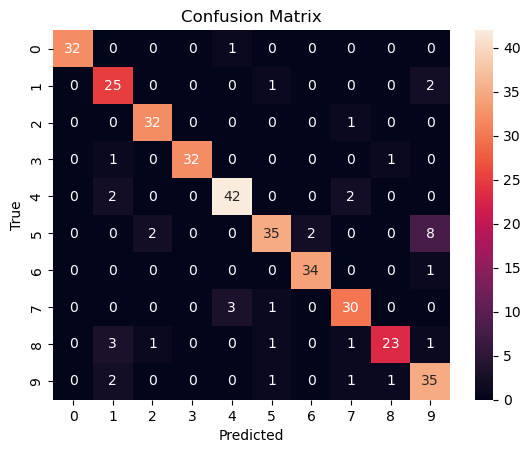

In [6]:
predictions = model.predict(x_test)
acc = compute_accuracy(predictions,y_test)
plot_predictions(x_test,predictions,acc)
plot_confusion_matrix(y_test,predictions)